In [133]:
import numpy as np
import os
from PIL import Image, ExifTags
from PIL import ImageOps, ImageEnhance
from PIL.ExifTags import TAGS
from datetime import datetime
import matplotlib.pyplot as plt

In [134]:
def load_band(filename, laser_height, band_width):
	img = Image.open(filename)
	img = ImageOps.exif_transpose(img)  # rotate image according to metadata
	# #only take green channel to better isolate the laser
	img = img.getchannel("G")
	img = img.crop((0, laser_height - band_width, img.width, laser_height + band_width))
	return img

In [135]:
def get_x_pixel(filename, laser_height=1350, band_width=50):
	# TODO: somehow incorporate uncertainties (maybe)
	img = np.array(load_band(filename, laser_height, band_width))
	averaged = img.mean(axis=0)
	return np.argmax(averaged)

In [136]:
def get_timestamp(filepath):
    try:
        img = Image.open(filepath)
        exif = img._getexif()
        if exif:
            for tag, value in exif.items():
                if TAGS.get(tag) == "DateTimeOriginal":
                    return datetime.strptime(value, "%Y:%m:%d %H:%M:%S")
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
    return None

def load_and_sort_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff'))]
    data = [(f, get_timestamp(f)) for f in files]
    data.sort(key=lambda x: x[1])
    return np.array(data)


In [137]:
def create_time_series(directory, laser_height=1350, band_width=50):
	images = load_and_sort_images(directory)
	first_time = images[0][1]
	return np.array([[(time - first_time).total_seconds(), get_x_pixel(image_path, laser_height, band_width)] for image_path, time in images])


In [138]:
def calculate_x_coordinates(series, meter_left_edge=1.18, meter_right_edge=2.5, image_width=4098):
    series_meters = np.copy(series)
    series_meters[:,1] = series_meters[:,1]/image_width * (meter_right_edge - meter_left_edge) + meter_left_edge
    return series_meters


In [139]:
# The tracker works by sorting all the images in a folder, then taking a thin slice (containing the laserpointer) of each image and looking for the brightest spot (in the green channel) for 

# Tutorial:
# - pick directory of the measurement and write that into the "directory" keyword below
# - determine the y-position of the laser and write the value into the keyword argument "laser_height" in "create_time_series" below
#    (if needed adjust the width of the band around which it cuts but ±50 pixels should be fine)
# - determine the left/right most increments of the measuring tape and write those values into the keyword-arguments "meter_left_edge", "meter_right_edge" in the keyword arguments of "calculate_x_coordinates"

series = create_time_series(
	directory = "./measurement1",
	laser_height=1350, 
	band_width=50
)
# WARNING: this might take up to 2-3 minutes every time it's executed

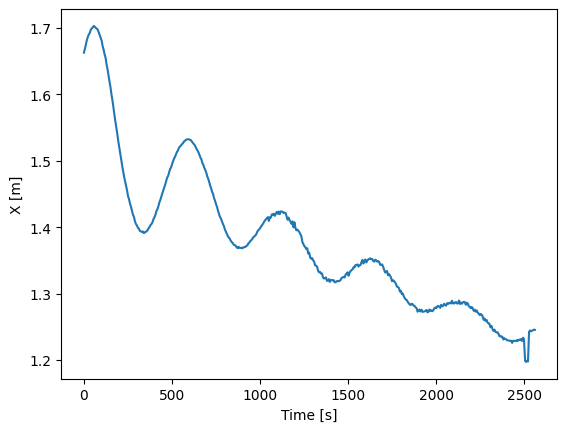

In [140]:
series_meter = calculate_x_coordinates(
	series,
	meter_left_edge=1.18,
	meter_right_edge=2.5,
	image_width=4098
)
plt.plot(*series_meter.T)
plt.xlabel("Time [s]")
plt.ylabel("X [m]")
plt.show()